In [1]:
import pandas as pd
import pandana as pdna
import time
import os

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

%matplotlib inline

In [2]:
# Pandana currently uses depreciated parameters in matplotlib, this hides the warning until its fixed
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [3]:
city='Hamburg'

Add feed for the city's GTFS data

In [4]:
if city=='Hamburg':
    feeds.add_feed(add_dict={'Hamburg': 'http://daten.transparenz.hamburg.de/Dataport.HmbTG.ZS.Webservice.GetRessource100/GetRessource100.svc/32aedec8-c69f-4053-a5e8-9b1267eb25de/Upload__HVV_Rohdaten_GTFS_Fpl_20190207.zip'})
    bbox = (9.972308, 53.513722,  10.033365, 53.558708)
elif city=='Boston':
    feeds.add_feed(add_dict={'Massachusetts Bay Transportation Authority': 'https://cdn.mbta.com/MBTA_GTFS.zip'})
    bbox = (-71.135117,42.318822,  -71.010919, 42.385857)

Added 1 feeds to gtfs_feeds: {'Hamburg': 'http://daten.transparenz.hamburg.de/Dataport.HmbTG.ZS.Webservice.GetRessource100/GetRessource100.svc/32aedec8-c69f-4053-a5e8-9b1267eb25de/Upload__HVV_Rohdaten_GTFS_Fpl_20190207.zip'}


Download GFTS data

In [5]:
os.chdir('./'+city)
gtfsfeeds.download()

1 GTFS feeds will be downloaded here: data/gtfsfeed_zips
Hamburg GTFS feed downloaded successfully. Took 139.48 seconds for 29,303,447.0KB
GTFS feed download completed. Took 139.48 seconds
Hamburg.zip successfully extracted to: data/gtfsfeed_text/Hamburg
GTFS feed zipfile extraction completed. Took 1.81 seconds for 1 files


Load GTFS data into an UrbanAccess transit data object

In [6]:
validation = True
verbose = True
remove_stops_outsidebbox = True
append_definitions = True

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=None,
                                           validation=validation,
                                           verbose=verbose,
                                           bbox=bbox,
                                           remove_stops_outsidebbox=remove_stops_outsidebbox,
                                           append_definitions=append_definitions)

GTFS text file header whitespace check completed. Took 3.09 seconds
--------------------------------
Processing GTFS feed: Hamburg
agency.txt agency_name column has more than one agency name listed. Unique agency id was assigned using the agency id and associated agency name.
Unique agency id operation complete. Took 32.99 seconds
Unique GTFS feed id operation complete. Took 0.02 seconds
Records: {}
              stop_id  stop_code                               stop_name  \
0        000000010000        NaN                        Billhorner Deich   
4        000000010005        NaN                       Borgfelder Straße   
5        000000010006        NaN                            U Burgstraße   
6        000000010007        NaN                                  Saling   
7        000000010008        NaN                  Beim Hammer Marktplatz   
8        000000010009        NaN                         U Hammer Kirche   
9        000000010010        NaN                               Hü

Appended route type to stops
Appended route type to stop_times
--------------------------------
Added descriptive definitions to stops, routes, stop_times, and trips tables
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 0.73 seconds
1 GTFS feed file(s) successfully read as dataframes:
     Hamburg
     Took 42.47 seconds


Quickly view the transit stop locations

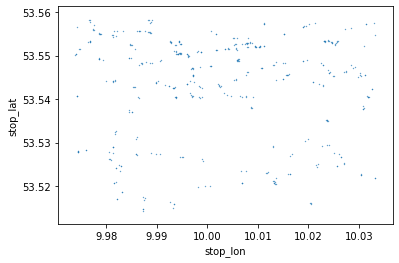

In [7]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

Create a travel time weighted graph for weekday `monday` service between 7 am and 10 am (`['07:00:00', '10:00:00']`) to represent travel times during the AM Peak period

In [8]:
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
235 service_ids were extracted from calendar
36,268 trip(s) 48.76 percent of 74,378 total trip records were found in calendar for GTFS feed(s): ['hamburg']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
36,268 of 74,378 total trips were extracted representing calendar day: monday. Took 0.33 seconds
There are no departure time records missing from trips following monday schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 5.14 seconds
Stop times from 07:00:00 to 10:00:00 successfully selec

Create a reference to the global network object called `urbanaccess_net`

In [9]:
urbanaccess_net = ua.network.ua_network

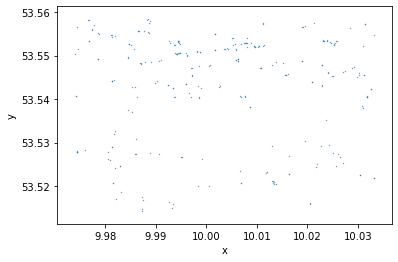

In [10]:
urbanaccess_net.transit_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

# Download OSM data

In [11]:
nodes, edges = ua.osm.load.ua_network_from_bbox(bbox=bbox,
                                                remove_lcn=True)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](53.51372200,9.97230800,53.55870800,10.03336500);>;);out;'}"
Downloaded 5,575.8KB from www.overpass-api.de in 1.33 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 1.51 seconds
Returning OSM data with 32,480 nodes and 9,651 ways...
Edge node pairs completed. Took 48.74 seconds
Returning processed graph with 11,592 nodes and 34,140 edges...
Completed OSM data download and Pandana node and edge table creation in 52.37 seconds
checking for low connectivity nodes...
62 out of 11,592 nodes (0.53 percent of total) were identified as having low connectivity and have been removed.
Completed OSM data download and graph node and edge table creation in 7

Create a travel time weighted graph from the pedestrian network - assume a pedestrian travels on average at 3 mph.
The resulting weighted network will be added to your UrbanAccess network object inside `osm_nodes` and `osm_edges`

In [12]:
ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.01 seconds


In [13]:
urbanaccess_net.osm_nodes.head()

x          y      id net_type
id                                           
122324  10.024134  53.529239  122324     walk
122329  10.031002  53.537496  122329     walk
122332  10.032257  53.539048  122332     walk
122349   9.985260  53.547938  122349     walk
122351   9.977550  53.549309  122351     walk

In [14]:
urbanaccess_net.osm_edges.head()

access area bridge    distance        from  hgv  \
13879893   201841968     NaN  NaN    NaN  116.424969    13879893  NaN   
201841968  13879893      NaN  NaN    NaN  116.424969   201841968  NaN   
13777944   2295536778    NaN  NaN    NaN    7.843474    13777944  NaN   
2295536778 13777944      NaN  NaN    NaN    7.843474  2295536778  NaN   
           2295536771    NaN  NaN    NaN   81.725541  2295536778  NaN   

                            highway junction lanes maxspeed          name  \
13879893   201841968   unclassified      NaN   NaN       50  Kurze Mühren   
201841968  13879893    unclassified      NaN   NaN       50  Kurze Mühren   
13777944   2295536778    pedestrian      NaN   NaN      NaN  Lange Mühren   
2295536778 13777944      pedestrian      NaN   NaN      NaN  Lange Mühren   
           2295536771    pedestrian      NaN   NaN      NaN  Lange Mühren   

                      oneway  ref service          to tunnel width    weight  \
13879893   201841968     NaN  NaN     NaN   201841968    NaN   NaN  1.446866   
201841968  13879893      NaN  NaN     NaN    13879893    NaN   NaN  1.446866   
13777944   2295536778    NaN  NaN     NaN  2295536778    NaN   NaN  0.097474   
2295536778 13777944      NaN  NaN     NaN    13777944    NaN   NaN  0.097474   
           2295536771    NaN  NaN     NaN  2295536771    NaN   NaN  1.015640   

                      net_type  
13879893   201841968      walk  
201841968  13879893       walk  
13777944   2295536778     walk  
2295536778 13777944       walk  
           2295536771     walk

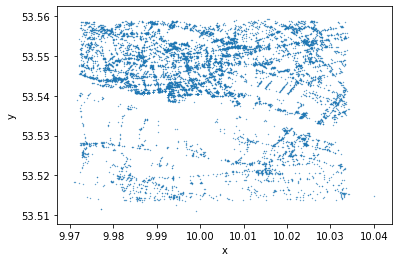

In [15]:
urbanaccess_net.osm_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

Add average transit headways

In [16]:
ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=['07:00:00','10:00:00'])

Stop times from 07:00:00 to 10:00:00 successfully selected 7,363 records out of 41,209 total records (17.87 percent of total). Took 0.01 seconds
Starting route stop headway calculation for 457 route stops...
Route stop headway calculation complete. Took 2.57 seconds
headway calculation complete. Took 3.06 seconds


In [17]:
loaded_feeds.headways.head()

count   mean       std   min   25%   50%    75%   max  \
1617    2.0  60.00  0.000000  60.0  60.0  60.0  60.00  60.0   
1623    2.0  60.00  0.000000  60.0  60.0  60.0  60.00  60.0   
1629    2.0  60.00  0.000000  60.0  60.0  60.0  60.00  60.0   
1953   16.0  10.25  1.125463   8.0  10.0  10.0  10.25  13.0   
1967   16.0  10.25  1.125463   8.0  10.0  10.0  10.25  13.0   

                                      unique_stop_id  \
1617  000000100001_G_hamburger_verkehrsverbund_(hvv)   
1623  000000100001_G_hamburger_verkehrsverbund_(hvv)   
1629  000000100001_G_hamburger_verkehrsverbund_(hvv)   
1953  000000100001_G_hamburger_verkehrsverbund_(hvv)   
1967  000000100001_G_hamburger_verkehrsverbund_(hvv)   

                             unique_route_id  \
1617  1177_3_hamburger_verkehrsverbund_(hvv)   
1623  1177_3_hamburger_verkehrsverbund_(hvv)   
1629  1177_3_hamburger_verkehrsverbund_(hvv)   
1953  6955_3_hamburger_verkehrsverbund_(hvv)   
1967  6955_3_hamburger_verkehrsverbund_(hvv)   

                                          node_id_route  
1617  000000100001_G_hamburger_verkehrsverbund_(hvv)...  
1623  000000100001_G_hamburger_verkehrsverbund_(hvv)...  
1629  000000100001_G_hamburger_verkehrsverbund_(hvv)...  
1953  000000100001_G_hamburger_verkehrsverbund_(hvv)...  
1967  000000100001_G_hamburger_verkehrsverbund_(hvv)...

In [18]:
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

Loaded UrbanAccess network components comprised of:
     Transit: 277 nodes and 6,008 edges;
     OSM: 11,530 nodes and 33,990 edges
routes successfully joined to transit nodes. Took 0.04 seconds
Connector edges between the OSM and transit network nodes successfully completed. Took 0.26 seconds
mean route stop headway will be used for pedestrian to transit edge impedance.
Headway impedance calculation completed. Took 0.02 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 0.79 seconds
Network edge and node network integration completed successfully resulting in a total of 11,973 nodes and 47,702 edges:
     Transit: 443 nodes 6,008 edges;
     OSM: 11,530 nodes 33,990 edges; and
     OSM/Transit connector: 7,704 edges.


# Create an integrated transit and pedestrian network

In [19]:
urbanaccess_net.net_nodes.head()

id net_type          x  \
id_int                                                                          
1       090000109008_hamburger_verkehrsverbund_(hvv)_1...      NaN  10.018928   
2       090000109014_hamburger_verkehrsverbund_(hvv)_1...      NaN  10.009659   
3       090000109018_hamburger_verkehrsverbund_(hvv)_1...      NaN  10.006168   
4       090000119007_hamburger_verkehrsverbund_(hvv)_1...      NaN  10.000655   
5       090000119004_hamburger_verkehrsverbund_(hvv)_1...      NaN   9.993552   

                y  
id_int             
1       53.556617  
2       53.552024  
3       53.549250  
4       53.547715  
5       53.552347

In [20]:
urbanaccess_net.net_edges.head()

access area bridge  distance  \
0    nan  nan    nan       NaN   
1    nan  nan    nan       NaN   
2    nan  nan    nan       NaN   
3    nan  nan    nan       NaN   
4    nan  nan    nan       NaN   

                                                from  hgv highway  \
0  090000109008_hamburger_verkehrsverbund_(hvv)_1...  nan     nan   
1  090000109014_hamburger_verkehrsverbund_(hvv)_1...  nan     nan   
2  090000109018_hamburger_verkehrsverbund_(hvv)_1...  nan     nan   
3  090000119007_hamburger_verkehrsverbund_(hvv)_1...  nan     nan   
4  090000109008_hamburger_verkehrsverbund_(hvv)_1...  nan     nan   

                                      edge_id junction lanes  ... service  \
0  17336647_hamburger_verkehrsverbund_(hvv)_1      nan   nan  ...     nan   
1  17336647_hamburger_verkehrsverbund_(hvv)_2      nan   nan  ...     nan   
2  17336647_hamburger_verkehrsverbund_(hvv)_3      nan   nan  ...     nan   
3  17336647_hamburger_verkehrsverbund_(hvv)_4      nan   nan  ...     nan   
4  17336906_hamburger_verkehrsverbund_(hvv)_1      nan   nan  ...     nan   

                                                  to tunnel  \
0  090000109014_hamburger_verkehrsverbund_(hvv)_1...    nan   
1  090000109018_hamburger_verkehrsverbund_(hvv)_1...    nan   
2  090000119007_hamburger_verkehrsverbund_(hvv)_1...    nan   
3  090000119005_hamburger_verkehrsverbund_(hvv)_1...    nan   
4  090000109014_hamburger_verkehrsverbund_(hvv)_1...    nan   

                  unique_agency_id                         unique_route_id  \
0  hamburger_verkehrsverbund_(hvv)  1466_1_hamburger_verkehrsverbund_(hvv)   
1  hamburger_verkehrsverbund_(hvv)  1466_1_hamburger_verkehrsverbund_(hvv)   
2  hamburger_verkehrsverbund_(hvv)  1466_1_hamburger_verkehrsverbund_(hvv)   
3  hamburger_verkehrsverbund_(hvv)  1466_1_hamburger_verkehrsverbund_(hvv)   
4  hamburger_verkehrsverbund_(hvv)  1466_1_hamburger_verkehrsverbund_(hvv)   

                             unique_trip_id weight  width  from_int to_int  
0  17336647_hamburger_verkehrsverbund_(hvv)    3.0    nan         1      2  
1  17336647_hamburger_verkehrsverbund_(hvv)    1.0    nan         2      3  
2  17336647_hamburger_verkehrsverbund_(hvv)    1.0    nan         3      4  
3  17336647_hamburger_verkehrsverbund_(hvv)    2.0    nan         4    375  
4  17336906_hamburger_verkehrsverbund_(hvv)    3.0    nan         1      2  

[5 rows x 29 columns]

In [21]:
urbanaccess_net.net_edges[urbanaccess_net.net_edges['net_type'] == 'transit'].head()

access area bridge  distance  \
0    nan  nan    nan       NaN   
1    nan  nan    nan       NaN   
2    nan  nan    nan       NaN   
3    nan  nan    nan       NaN   
4    nan  nan    nan       NaN   

                                                from  hgv highway  \
0  090000109008_hamburger_verkehrsverbund_(hvv)_1...  nan     nan   
1  090000109014_hamburger_verkehrsverbund_(hvv)_1...  nan     nan   
2  090000109018_hamburger_verkehrsverbund_(hvv)_1...  nan     nan   
3  090000119007_hamburger_verkehrsverbund_(hvv)_1...  nan     nan   
4  090000109008_hamburger_verkehrsverbund_(hvv)_1...  nan     nan   

                                      edge_id junction lanes  ... service  \
0  17336647_hamburger_verkehrsverbund_(hvv)_1      nan   nan  ...     nan   
1  17336647_hamburger_verkehrsverbund_(hvv)_2      nan   nan  ...     nan   
2  17336647_hamburger_verkehrsverbund_(hvv)_3      nan   nan  ...     nan   
3  17336647_hamburger_verkehrsverbund_(hvv)_4      nan   nan  ...     nan   
4  17336906_hamburger_verkehrsverbund_(hvv)_1      nan   nan  ...     nan   

                                                  to tunnel  \
0  090000109014_hamburger_verkehrsverbund_(hvv)_1...    nan   
1  090000109018_hamburger_verkehrsverbund_(hvv)_1...    nan   
2  090000119007_hamburger_verkehrsverbund_(hvv)_1...    nan   
3  090000119005_hamburger_verkehrsverbund_(hvv)_1...    nan   
4  090000109014_hamburger_verkehrsverbund_(hvv)_1...    nan   

                  unique_agency_id                         unique_route_id  \
0  hamburger_verkehrsverbund_(hvv)  1466_1_hamburger_verkehrsverbund_(hvv)   
1  hamburger_verkehrsverbund_(hvv)  1466_1_hamburger_verkehrsverbund_(hvv)   
2  hamburger_verkehrsverbund_(hvv)  1466_1_hamburger_verkehrsverbund_(hvv)   
3  hamburger_verkehrsverbund_(hvv)  1466_1_hamburger_verkehrsverbund_(hvv)   
4  hamburger_verkehrsverbund_(hvv)  1466_1_hamburger_verkehrsverbund_(hvv)   

                             unique_trip_id weight  width  from_int to_int  
0  17336647_hamburger_verkehrsverbund_(hvv)    3.0    nan         1      2  
1  17336647_hamburger_verkehrsverbund_(hvv)    1.0    nan         2      3  
2  17336647_hamburger_verkehrsverbund_(hvv)    1.0    nan         3      4  
3  17336647_hamburger_verkehrsverbund_(hvv)    2.0    nan         4    375  
4  17336906_hamburger_verkehrsverbund_(hvv)    3.0    nan         1      2  

[5 rows x 29 columns]

Plot the combined network

In [22]:
edgecolor_weight = ua.plot.col_colors(df=urbanaccess_net.net_edges, col='weight', cmap='gist_heat_r', num_bins=5)

In [23]:
edgecolor_type=list(urbanaccess_net.net_edges.apply(lambda row: (1,0,0,1) if row['net_type']=='transit' else (127/255,201/255,127/255, 1), axis=1))

Plot by link type

Figure created. Took 10.65 seconds


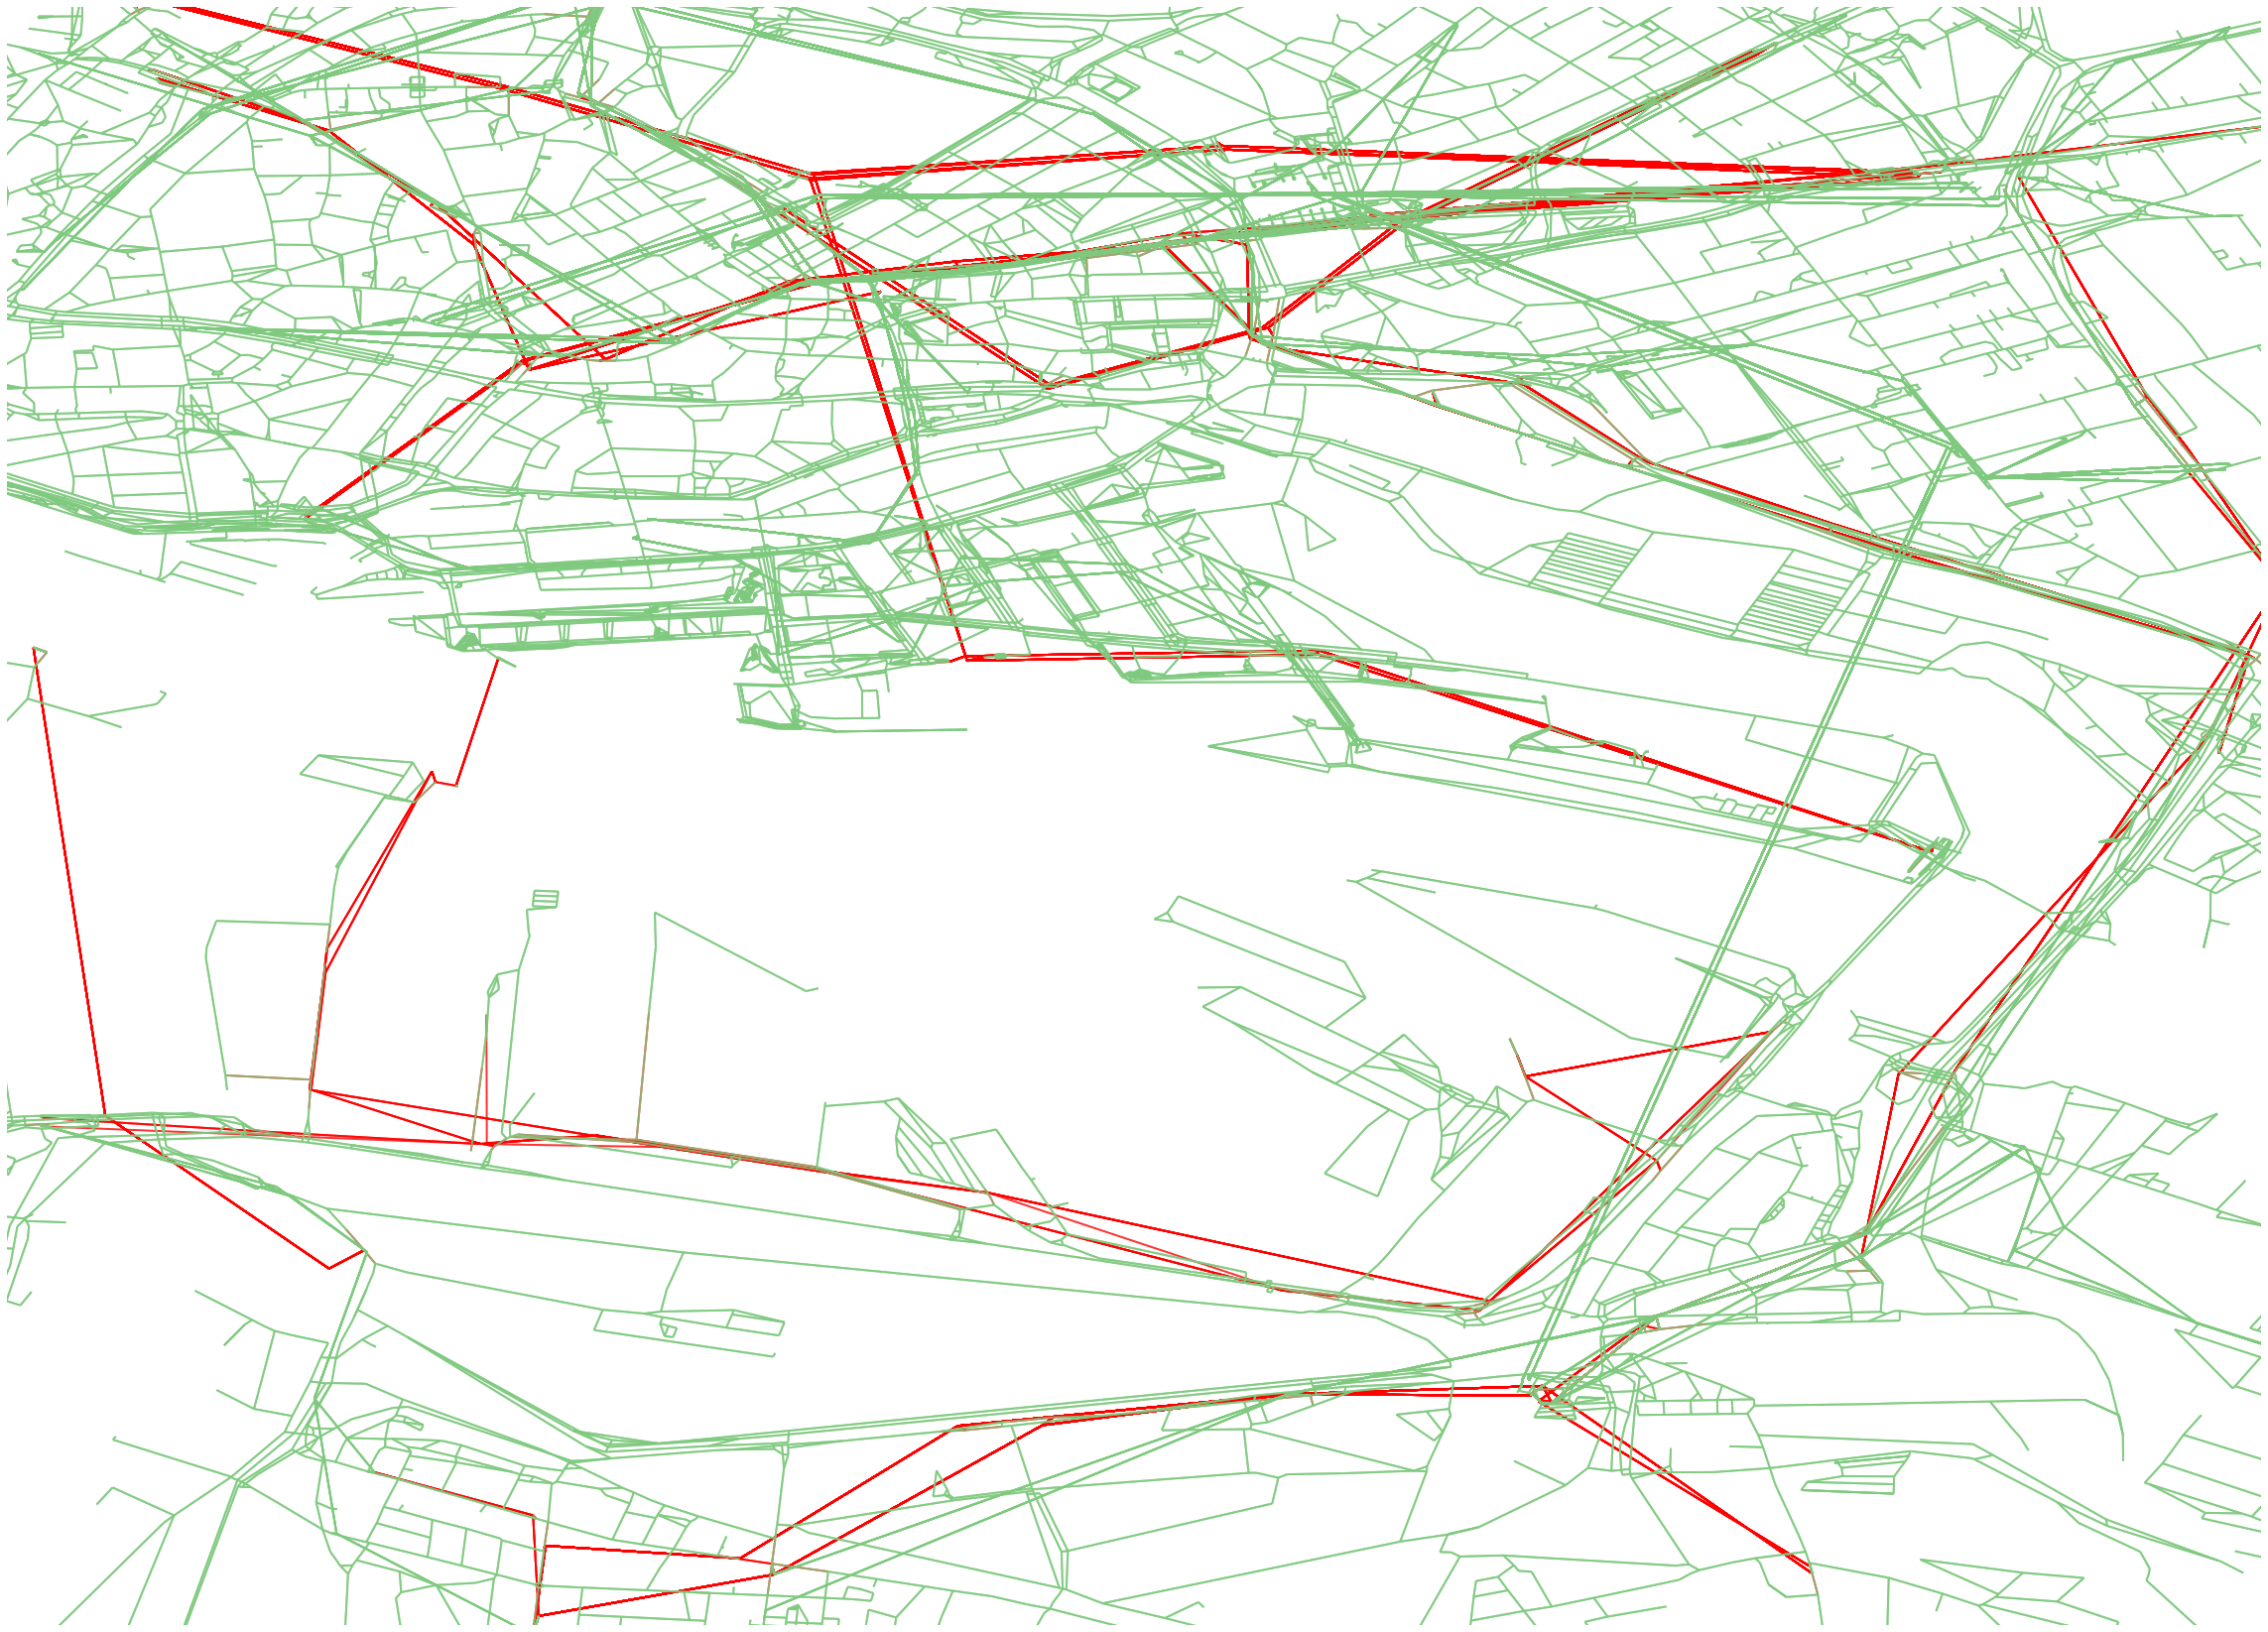

(<Figure size 2931.65x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14e9d11d0>)

In [24]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color=edgecolor_type, edge_linewidth=2, edge_alpha=0.8,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

Figure created. Took 9.67 seconds


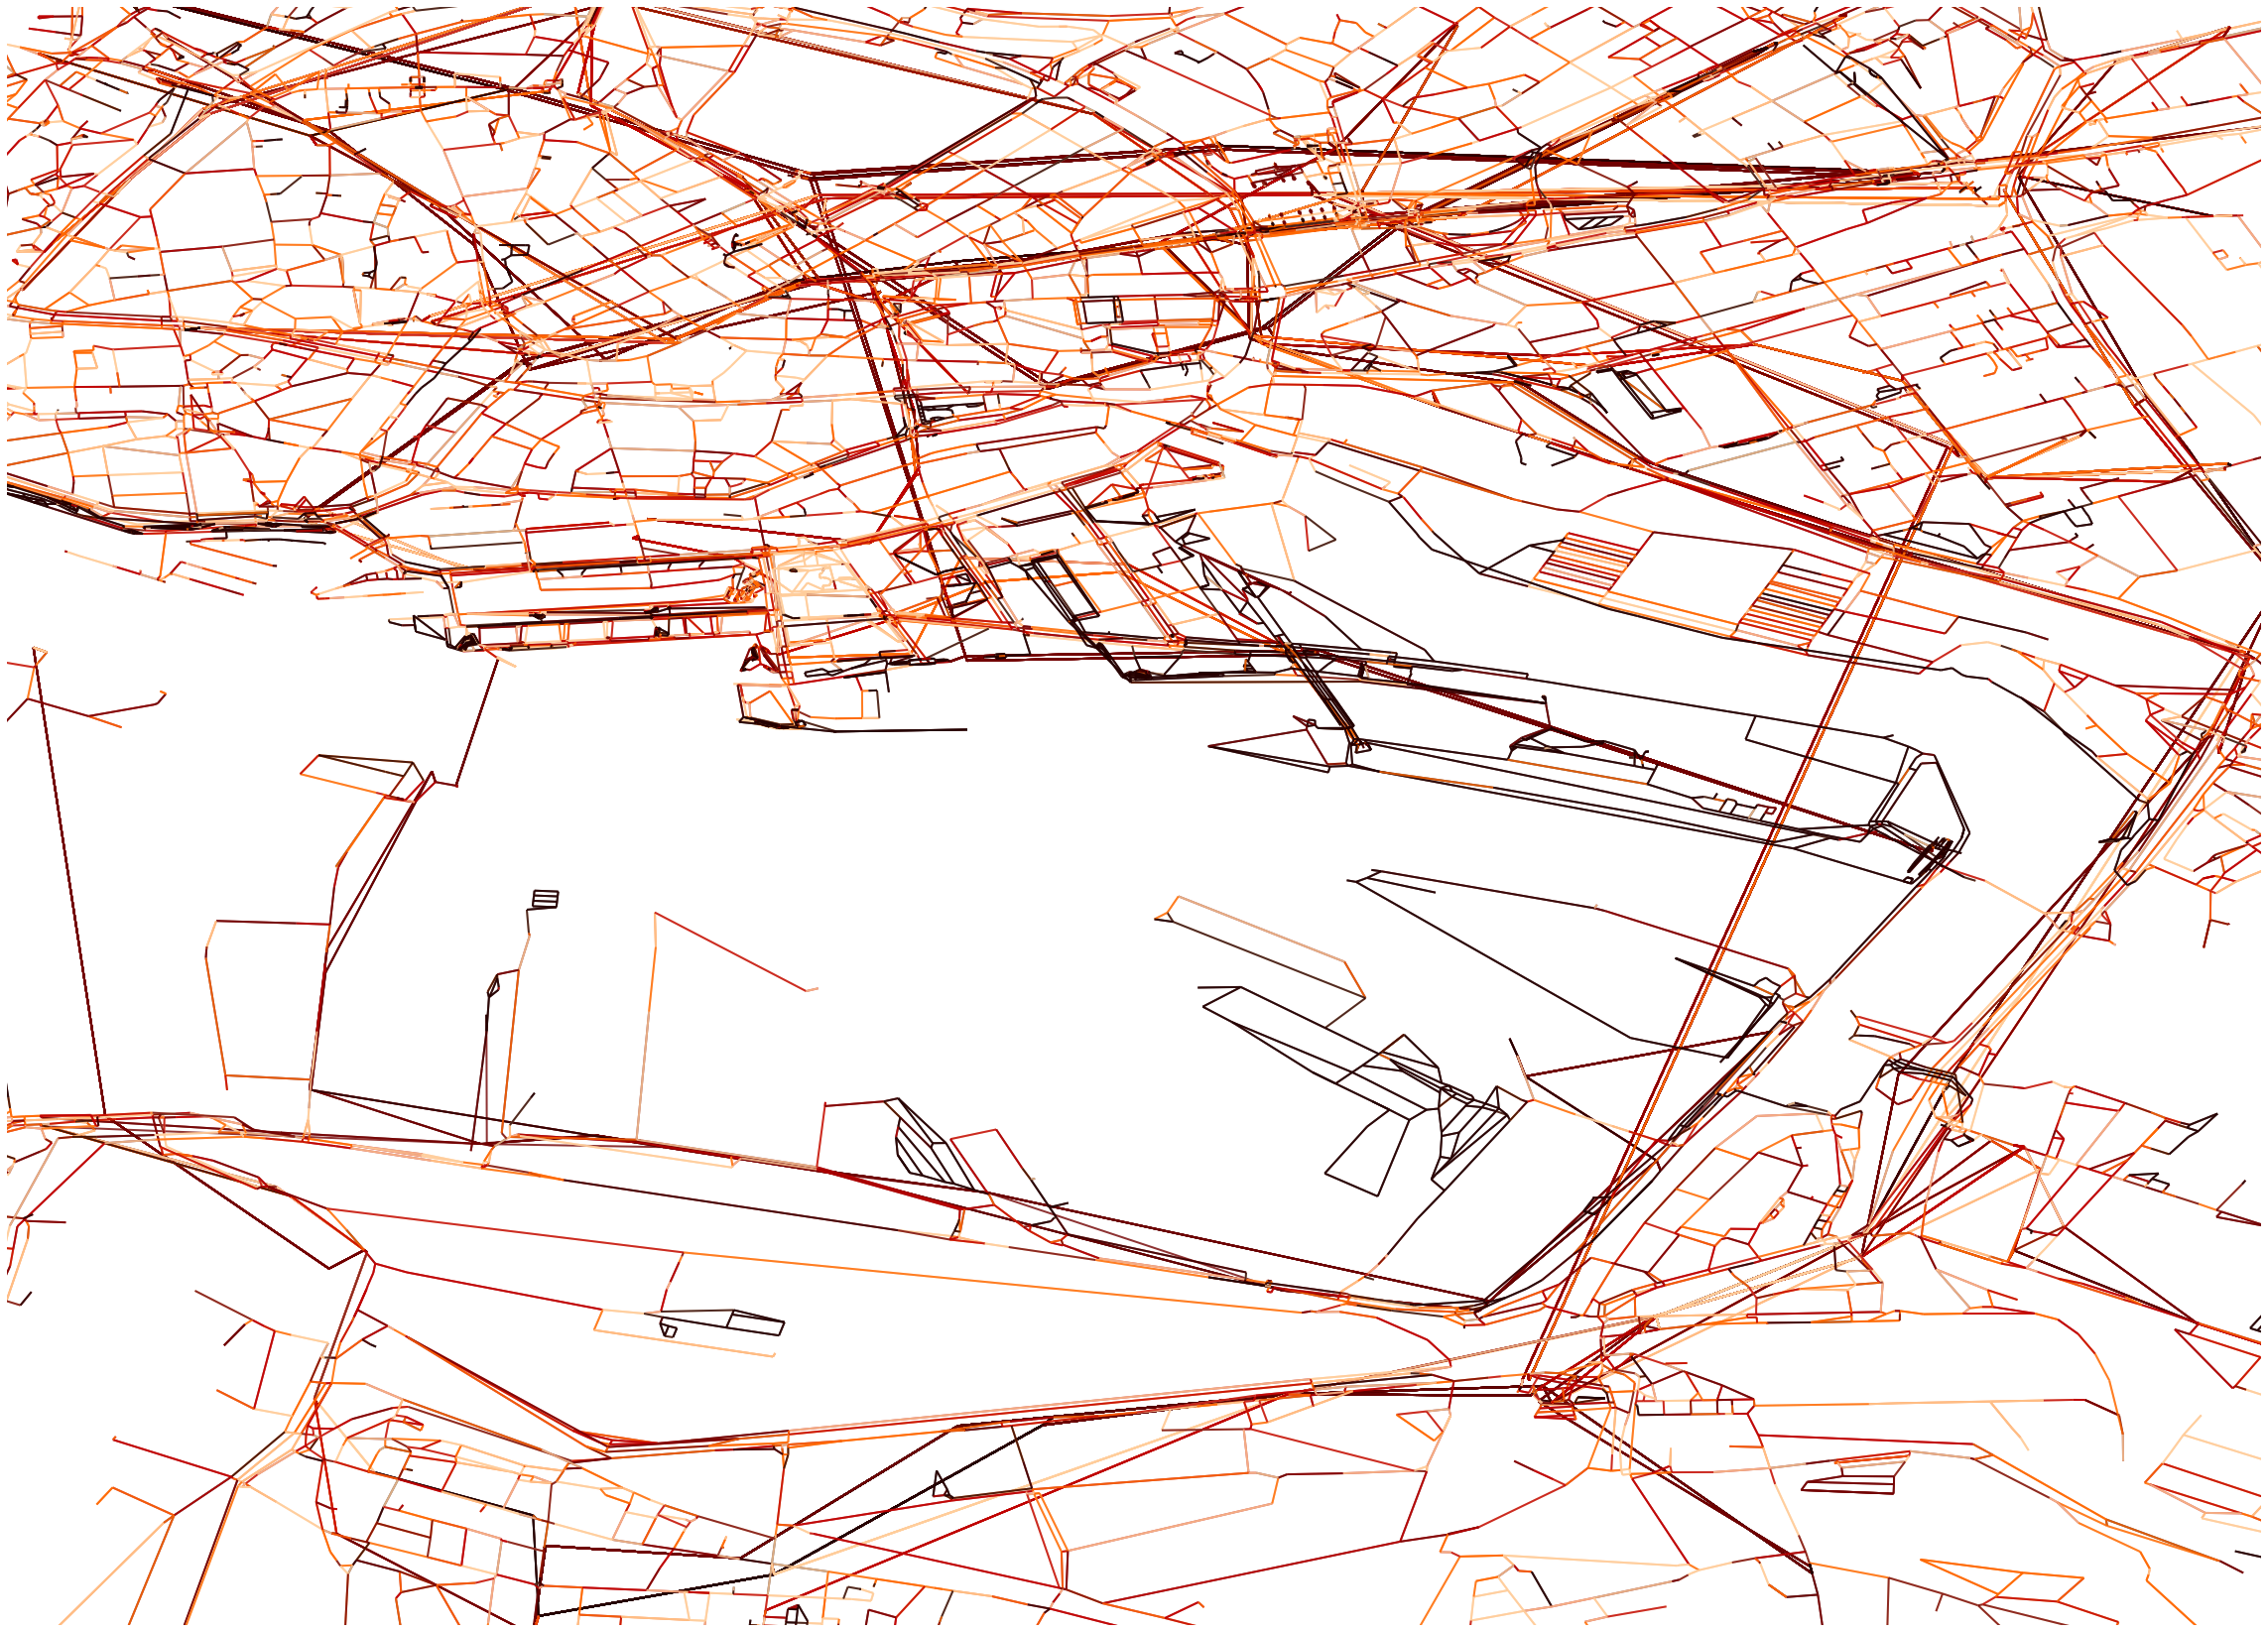

(<Figure size 2931.65x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13d7b25f8>)

In [25]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color=edgecolor_weight, edge_linewidth=2, edge_alpha=0.8,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

# Using an UrbanAccess network with Pandana

- set any Pandana `two_way` parameters to `False` (they are `True` by default) to indicate that the network is a one way network.
- `node ids` and `from` and `to` columns in your network must be integer type and not string. 
- edge weights represent travel time in minutes.

## Initialize the Pandana network

Let's initialize our Pandana network object using our transit and pedestrian network we created. Note: the `from_int` and `to_int` as well as the `twoway=False` denoting this is a explicit one way network.

In [26]:
s_time = time.time()
transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)
print('Took {:,.2f} seconds'.format(time.time() - s_time))

Took 3.39 seconds


In [27]:
s_time = time.time()
transit_ped_net.precompute(20)
print('Took {:,.2f} seconds'.format(time.time() - s_time))

Took 10.52 seconds


Get amenity data

In [28]:
import urllib.request
import json
# =============================================================================
# Constants
# =============================================================================
OSM_URL_ROOT='https://lz4.overpass-api.de/api/interpreter?data=[out:json][bbox];node[~"^(amenity|leisure|shop)$"~"."];out;&bbox='

tags={
      'food': ['amenity_restaurant', 'amenity_cafe' 'amenity_fast_food', 'amenity_pub'],
      'nightlife': ['amenity_bar' , 'amenity_pub' , 'amenity_nightclub', 'amenity_biergarten'],  #(according to OSM, pubs may provide food, bars dont)
      'groceries': ['shop_convenience', 'shop_grocer', 'shop_greengrocer', 'shop_food', 'shop_supermarket'], 
      'education': ['amenity_school', 'amenity_university', 'amenity_college']
      }
# =============================================================================
# get all amenities in within bounding box of study area
# =============================================================================
bounds_all=lng_min, lat_min, lng_max, lat_max = bbox
# To get all amenity data
str_bounds=str(bounds_all[0])+','+str(bounds_all[1])+','+str(bounds_all[2])+','+str(bounds_all[3])
osm_url_bbox=OSM_URL_ROOT+str_bounds
with urllib.request.urlopen(osm_url_bbox) as url:
    data=json.loads(url.read().decode())

In [29]:
# =============================================================================
# Create a list including only the amenity types we're interested in
# include each possible tag as a property
# =============================================================================
amenities=[]
for a in range(len(data['elements'])):
    include=0
    for t in tags:
        data['elements'][a][t]=0
        for recordTag in list(data['elements'][a]['tags'].items()):
            if recordTag[0] +'_'+recordTag[1] in tags[t]:
                data['elements'][a][t]=1
                include=1
    if include==1:
        new_amenity={t: data['elements'][a][t] for t in tags}
        new_amenity['x']=data['elements'][a]['lon']
        new_amenity['y']=data['elements'][a]['lat']
        amenities.append(new_amenity)

In [30]:
amenities_df=pd.DataFrame(amenities)

In [32]:
amenities_df.head()

education  food  groceries  nightlife          x          y
0          0     1          0          0   9.981032  53.550525
1          1     0          0          0  10.021803  53.554989
2          0     1          0          0   9.991686  53.555718
3          0     1          0          0  10.023296  53.544805
4          0     1          0          0  10.028644  53.545120

In [33]:
for t in tags:
    transit_ped_net.set_pois(t, 20, 10, amenities_df.loc[amenities_df[t]==1, 'x'], amenities_df.loc[amenities_df[t]==1, 'y'])

In [34]:
dist_to_second={}
for t in tags:
    dist_to_second[t]=transit_ped_net.nearest_pois(20, t, num_pois=2).loc[:,2]

In [35]:
import matplotlib.pyplot as plt

In [36]:
color_scale=['#a50026',
'#d73027',
'#f46d43',
'#fdae61',
'#fee08b',
'#ffffbf',
'#d9ef8b',
'#a6d96a',
'#66bd63',
'#1a9850',
'#006837']

scale, colors={},{}
for t in tags:
    scale[t]=[1-(dist_to_second[t].iloc[i]/15) for i in range(len(dist_to_second[t]))]
for s in scale:
    colors[s]=[color_scale[int(scale[s][i]*10)] for i in range(len(scale[s]))]

# Amenity Accessibility
## Food

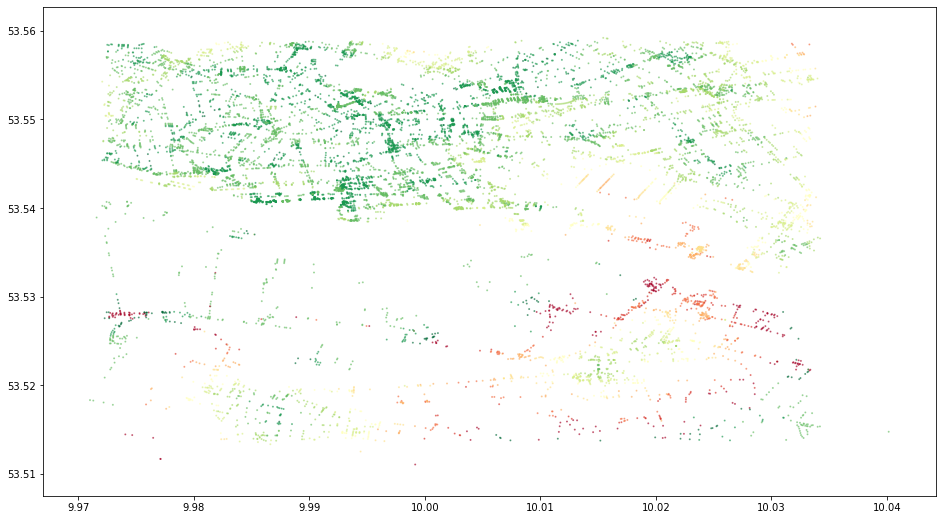

In [37]:
fig=plt.figure(figsize=(16,9))
plt.scatter(transit_ped_net.nodes_df["x"],
         transit_ped_net.nodes_df["y"],
        color=colors['food'], alpha=0.5, s=1)

## Groceries

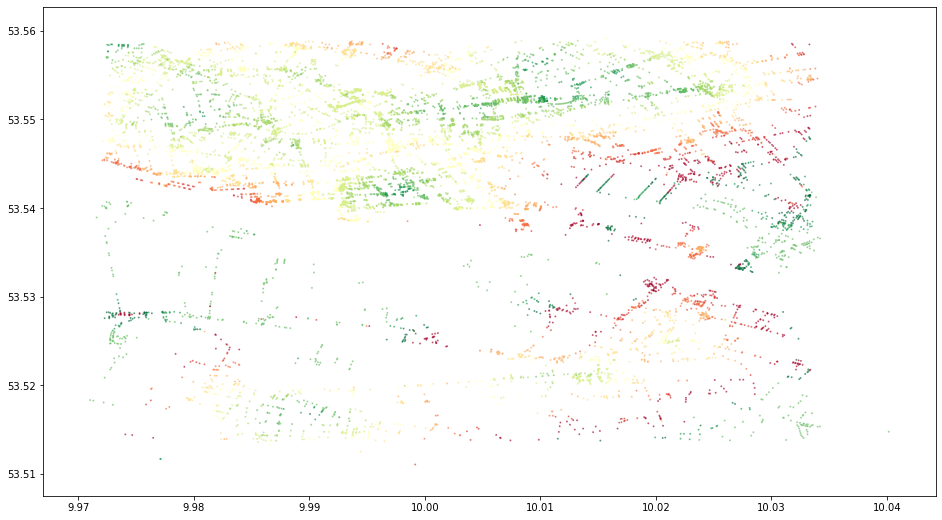

In [38]:
fig=plt.figure(figsize=(16,9))
plt.scatter(transit_ped_net.nodes_df["x"],
         transit_ped_net.nodes_df["y"],
        color=colors['groceries'], alpha=0.5, s=1)

# Nightlife

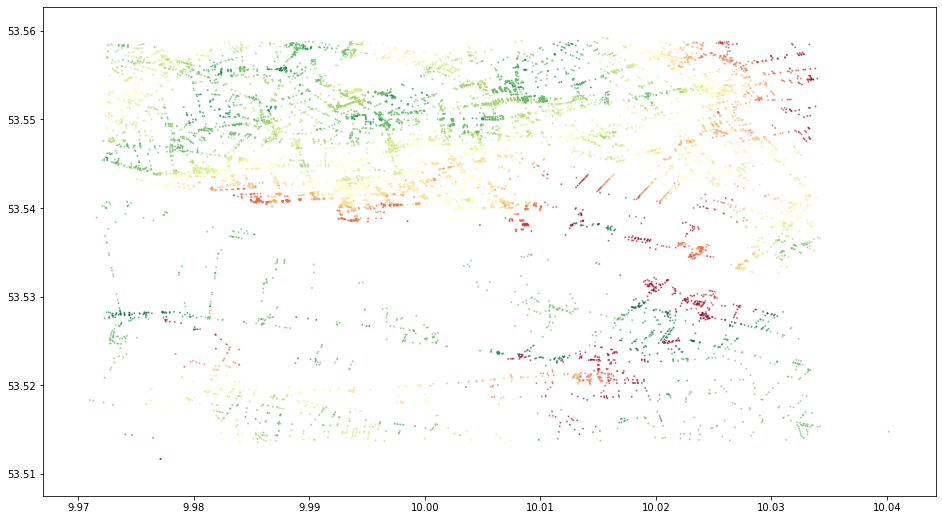

In [39]:
fig=plt.figure(figsize=(16,9))
plt.scatter(transit_ped_net.nodes_df["x"],
         transit_ped_net.nodes_df["y"],
        color=colors['nightlife'], alpha=0.5, s=1)

## Education

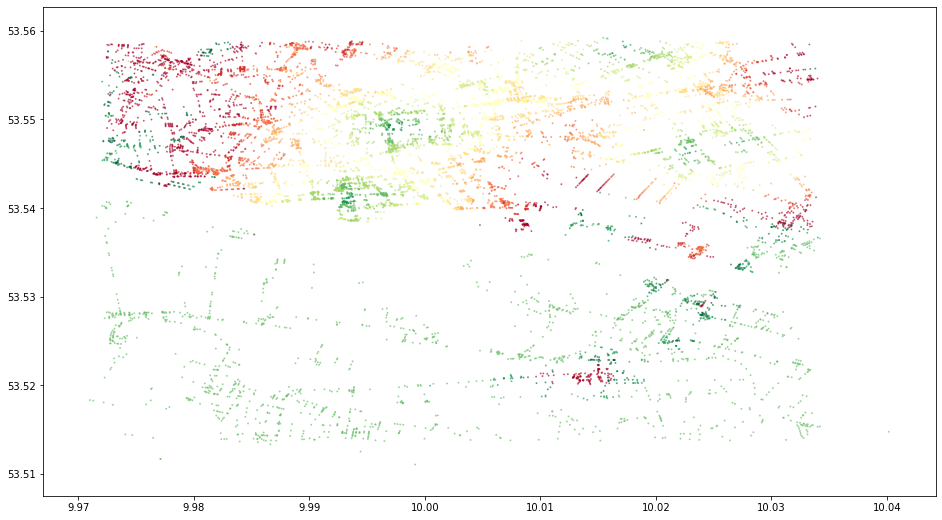

In [40]:
fig=plt.figure(figsize=(16,9))
plt.scatter(transit_ped_net.nodes_df["x"],
         transit_ped_net.nodes_df["y"],
        color=colors['education'], alpha=0.5, s=1)

Save the pandana network (just the network, no associated data)

In [44]:
transit_ped_net.save_hdf5('./data/combined_network.hdf5')

Save the amenity dataframes

In [43]:
amenities_df.to_csv('./data/amenities.csv', index=False)